In [ ]:
from google.colab import drive
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
import csv
import random
import collections
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn import ensemble
import os
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/gdrive


### Import Data

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/train.csv', encoding='mac_roman') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  # skip column names
  X_train = []
  Y_train = []
  for row in csv_reader: 
      X_train.append(row[0])
      Y_train.append(row[1])

with open('/content/gdrive/MyDrive/Colab Notebooks/test.csv', encoding='mac_roman') as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)  # skip column names
  X_test = []
  test_ID = []
  for row in csv_reader: 
      X_test.append(row[1])
      test_ID.append(row[0])

### Define stemming and stopwords function

In [ ]:
from sklearn.feature_extraction import text 
from nltk.stem import PorterStemmer

my_stop_words = text.ENGLISH_STOP_WORDS

def stem(post):
  ps = PorterStemmer()
  return " ".join([ps.stem(word) for word in post.split(' ')])

def stopwords(post):
  return " ".join([word for word in post.split(' ') if not word in my_stop_words])

In [ ]:
X_train = [stem(stopwords(x)) for x in X_train]
X_test = [stem(stopwords(x)) for x in X_test]

### Vectorize training and test data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
my_stop_words = text.ENGLISH_STOP_WORDS
vectorizer = CountVectorizer(max_features=1000, strip_accents='ascii', binary = 'true', token_pattern = r'\b[a-zA-Z]{2,}\b') #applied stop words present in english_stop_words and stripped accents
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
print(vectorizer.get_feature_names())

['abil', 'abl', 'about', 'above', 'absolut', 'accept', 'access', 'accident', 'account', 'accounts', 'act', 'action', 'activ', 'activity', 'actual', 'ad', 'add', 'address', 'admin', 'ads', 'advanc', 'advance', 'advertis', 'advic', 'advice', 'affect', 'after', 'again', 'ago', 'algorithm', 'all', 'allow', 'also', 'altern', 'am', 'and', 'android', 'ani', 'annoy', 'annoying', 'answer', 'anybodi', 'anymor', 'anymore', 'anyon', 'anyone', 'anything', 'anyway', 'anywhere', 'api', 'app', 'appar', 'appeal', 'appear', 'appli', 'applic', 'appreci', 'appreciated', 'approach', 'apps', 'are', 'aren', 'art', 'articl', 'artist', 'as', 'ask', 'ass', 'associ', 'assum', 'at', 'attach', 'attempt', 'audio', 'authent', 'auto', 'automat', 'automatically', 'avail', 'avoid', 'awar', 'away', 'back', 'background', 'backup', 'bad', 'ban', 'banned', 'bar', 'base', 'basic', 'be', 'becaus', 'before', 'believ', 'best', 'better', 'big', 'billion', 'bit', 'black', 'block', 'blocked', 'blog', 'bot', 'both', 'bother', 'bot

### Enumeration to change y data to integers

In [ ]:
from enum import Enum

class Classes(Enum): 
    Telegram = 0 
    Linkedin = 1 
    Instagram = 2
    viber = 3
    Facebook = 4

Y_train_vect = [getattr(Classes, n).value for n in Y_train]

### Create wordcloud to visualize data


(-0.5, 743.5, 543.5, -0.5)

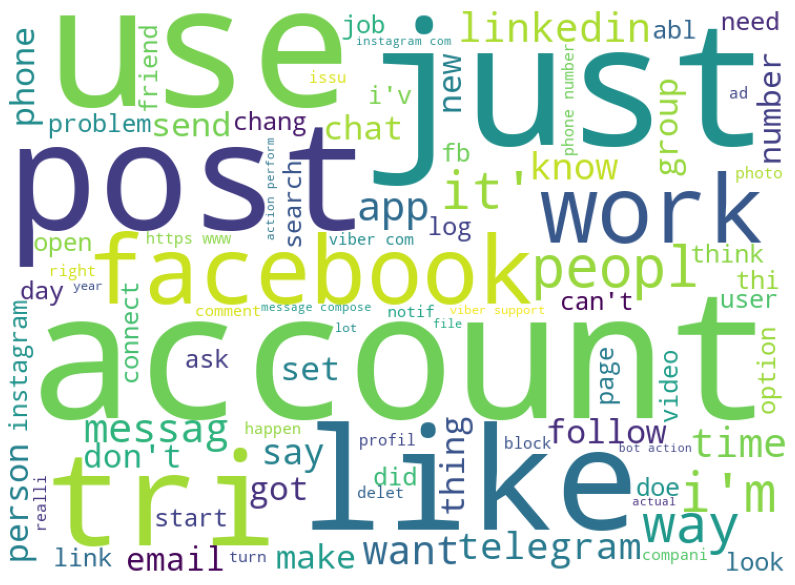

In [ ]:
#wordcloud of data
text = ' '
for x in X_train: 
      
    x = str(x) 
  
    values = x.split() 
      
    for i in range(len(values)): 
        values[i] = values[i].lower() 
          
    for words in values: 
        text = text + words + ' '
  
  
wc = WordCloud(max_words= 100,
                      width = 744, 
                      height = 544,
                      background_color ='white',
                      stopwords= my_stop_words, 
                      contour_width=3, 
                      contour_color='steelblue',
                      min_font_size = 10).generate(text) 
                      
plt.figure(figsize = (14, 14)) 
plt.imshow(wc) 
plt.axis("off")

### Naive-Bayes class


In [ ]:
class NVB:

  def __init__ (self, X_train_vect, Y_train_vect):
    counts = collections.Counter(Y_train_vect)
    self.prior = [counts[index]/len(Y_train_vect) for index in counts]

    self.posterior = []
    for i in range(5):
      sum = np.squeeze(np.asarray((np.divide(np.sum(np.array([X_train_vect[index] for index in range(len(Y_train_vect)) if Y_train_vect[index] == i]),axis=0),counts[i])).todense().T))
      self.posterior.append(np.column_stack((np.subtract(1,sum),sum)))

  def predict(self, X_test_vect):
    predictions = []
    for post in X_test_vect:
      problist = [self.probability(post,y) for y in range(5)]
      predictions.append(max(range(5), key=problist.__getitem__))
    return predictions 

  def probability(self,post, y):
    pi = self.prior[y]
    for index, feature in enumerate(post):
      pi *= self.posterior[y][index][feature]
    return pi

In [ ]:
model = NVB(X_train_vect, Y_train_vect)
model_predictions = model.predict(np.squeeze(np.asarray(X_train_vect.todense())))
print("Train accuracy:", accuracy_score(Y_train_vect,model_predictions))

Train accuracy: 0.9228130360205832


###Random Forest Classifier from sklearn

In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, max_depth = None, max_features = 'auto')
rfc.fit(X_train_vect, Y_train_vect)

train_predict_rfc = rfc.predict(X_train_vect)
print("Train accuracy:", accuracy_score(Y_train_vect,train_predict_rfc))

Train accuracy: 1.0


###10-fold cross validation for Naive Bayes Classifier

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle = True)
kf.get_n_splits(X_train_vect)

accuracies = []
counter = 0
for train_index, test_index in kf.split(X_train_vect):
  newX_train, newX_test = X_train_vect[train_index], X_train_vect[test_index]
  newY_train, newY_test = np.expand_dims(Y_train_vect, axis = 1)[train_index], np.expand_dims(Y_train_vect, axis = 1)[test_index]
  newY_train = np.squeeze(np.asarray(newY_train))
  model = NVB(newX_train, newY_train)
  model_predictions = model.predict(np.squeeze(np.asarray(newX_test.todense())))
  print("Test accuracy:", counter , accuracy_score(newY_test,model_predictions))
  accuracies.append(accuracy_score(newY_test,model_predictions))
  counter += 1
print("Cross Validate Accuracy:", np.mean(accuracies))

Test accuracy: 0 0.64
Test accuracy: 1 0.6685714285714286
Test accuracy: 2 0.72
Test accuracy: 3 0.6914285714285714
Test accuracy: 4 0.6742857142857143
Test accuracy: 5 0.64
Test accuracy: 6 0.7085714285714285
Test accuracy: 7 0.6114285714285714
Test accuracy: 8 0.6742857142857143
Test accuracy: 9 0.6896551724137931
Cross Validate Accuracy: 0.6718226600985222


10-fold cross validation for Random Forest Classifier

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle = True)
kf.get_n_splits(X_train_vect)

accuracies = []
counter = 0
for train_index, test_index in kf.split(X_train_vect):
  newX_train, newX_test = X_train_vect[train_index], X_train_vect[test_index]
  newY_train, newY_test = np.expand_dims(Y_train_vect, axis = 1)[train_index], np.expand_dims(Y_train_vect, axis = 1)[test_index]
  newY_train = np.squeeze(np.asarray(newY_train))
  rfc = ensemble.RandomForestClassifier(n_estimators = 600, min_samples_split = 2, max_depth = None, max_features = 'auto')
  rfc.fit(newX_train, newY_train)
  train_predict_rfc = rfc.predict(newX_test)
  print("Test accuracy:", counter , accuracy_score(newY_test,train_predict_rfc))
  accuracies.append(accuracy_score(newY_test,train_predict_rfc))
  counter += 1
print("Cross Validate Accuracy:", np.mean(accuracies))

Test accuracy: 0 0.8685714285714285
Test accuracy: 1 0.8514285714285714
Test accuracy: 2 0.8914285714285715
Test accuracy: 3 0.8571428571428571
Test accuracy: 4 0.8742857142857143
Test accuracy: 5 0.9142857142857143
Test accuracy: 6 0.8628571428571429
Test accuracy: 7 0.8628571428571429
Test accuracy: 8 0.92
Test accuracy: 9 0.8850574712643678
Cross Validate Accuracy: 0.8787914614121511


In [ ]:
rfc.fit(X_train_vect,Y_train_vect)
test_predict_vect = rfc.predict(X_test_vect)
test_predict = [Classes(num).name for num in test_predict_vect]

###Writing into csv file

In [ ]:
counter = 1
tmpFile = '/content/gdrive/MyDrive/Colab Notebooks/Submission.csv'
with open(tmpFile, "w") as file:
    writer = csv.writer(file, delimiter=',')
    row1 = ['id','subreddit']
    writer.writerow(row1)
    for i in test_predict:
      row = [counter,i]
      writer.writerow(row)
      counter+=1